In [1]:
%load_ext autoreload
%autoreload 2
import uproot, time, json, os, sys, hist, mplhep, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import sys
sys.path.append("../../analysisTools/")
from analysisTools import Analyzer
from analysisTools import loadSchema
import analysisTools as tools
import analysisSubroutines as routines
import plotTools as ptools
import importlib
import coffea.util as util
from coffea import util
from coffea.processor import accumulate

In [10]:
from matplotlib.lines import Line2D
def plotSignal(hname,xlim,rebin=1j,logy=False,scaley=5,xlabel=None,cut="cut7",nameVar="",flow=False):
    flow_str = "show" if flow else "none"
    for delta in deltas:
        fig,axes = plt.subplots(1,len(all_ctaus),figsize=(len(all_ctaus)*6,4))
        # plot signals
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for j,m1 in enumerate(m1s):
            ctaus = sorted(list(set(si[(si.delta==delta)&(si.m1==m1)].ctau)))
            for i,ct in enumerate(all_ctaus):
                if ct not in ctaus:
                    continue
                plt.sca(axes[i])
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][{"samp":point,"cut":cut}][::rebin]
                #mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
                mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca())
        
        for i in range(len(all_ctaus)):
            plt.sca(axes[i])
            if logy:
                plt.yscale('log')
            if not flow:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            if i==1:
                ncol = 2
                leg_entries = [Line2D([0],[0],color=f"C{j}",label=r"$M_1 = {0}$".format(m1s[j])) for j in range(len(m1s))]                    
                plt.gca().legend(handles=leg_entries,loc='upper center',bbox_to_anchor=(0.5,1),fontsize=10,ncol=ncol)
        
        #plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
        outDir = f"plots/histos/{cut}/sig_vs_bkg/{hname}{nameVar}/delta_{delta:.1f}/"
        outName = f"ct-all.pdf"
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        #plt.tight_layout()
        #plt.savefig(f"{outDir}/{outName}")
        
def plotBkg(hname,xlim,rebin=1j,logy=False,scaley=5,xlabel=None,cut="cut7",nameVar="",flow=False):
    flow_str = "show" if flow else "none"
    plt.figure(figsize=(6,4))
    h = bkg[hname][{"samp":sum,"cut":cut}]
    mplhep.histplot(h,label="Background",yerr=False,density=False,fill=True,color='gray',ax=plt.gca())
        
def plot(hname,xlim,rebin=1j,logy=False,scaley=5,xlabel=None,cut="cut7",nameVar="",flow=False):
    flow_str = "show" if flow else "none"
    
    bkg_stack = {b:bkg[hname][b] for b in bkg_histos.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    print(avail_cuts)
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}
    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)
    varAx = hb.axes[-1]
    for delta in deltas:
        fig,axes = plt.subplots(1,len(all_ctaus),figsize=(len(all_ctaus)*6,4))
        
        # plot bkgs
        for i in range(len(all_ctaus)):
            plt.sca(axes[i])
            plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,all_ctaus[i]))
            hb.plot(stack=True,yerr=False,density=False,histtype='fill',color=[k for k in mpl.colormaps['Set3'].colors][:nb])
            if i==0:
                ncol = 2
                plt.legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=10,ncol=ncol)
        
        # plot signals
        m1s = sorted(list(set(si[si.delta==delta].m1)))
        for j,m1 in enumerate(m1s):
            ctaus = sorted(list(set(si[(si.delta==delta)&(si.m1==m1)].ctau)))
            for i,ct in enumerate(all_ctaus):
                if ct not in ctaus:
                    continue
                plt.sca(axes[i])
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][{"samp":point,"cut":cut}][::rebin]
                mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
        
        for i in range(len(all_ctaus)):
            plt.sca(axes[i])
            if logy:
                plt.yscale('log')
            if not flow:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            if i==1:
                ncol = 2
                leg_entries = [Line2D([0],[0],color=f"C{j}",label=r"$M_1 = {0}$".format(m1s[j])) for j in range(len(m1s))]                    
                plt.gca().legend(handles=leg_entries,loc='upper center',bbox_to_anchor=(0.5,1),fontsize=10,ncol=ncol)
        
        #plt.suptitle(r"$\Delta = {0:.1f}$".format(delta))
        outDir = f"plots/histos/{cut}/sig_vs_bkg/{hname}{nameVar}/delta_{delta:.1f}/"
        outName = f"ct-all.pdf"
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        #plt.tight_layout()
        #plt.savefig(f"{outDir}/{outName}")
        
        # new figures split up by ctau
        ctaus = sorted(list(set(si[(si.delta==delta)].ctau)))
        for ct in ctaus:
            plt.figure(figsize=(8,6))
            hb.plot(stack=True,yerr=False,density=False,histtype='fill',color=[k for k in mpl.colormaps['Set3'].colors][:nb])
            m1s = sorted(list(set(si[(si.delta==delta)&(si.ctau==ct)].m1)))
            for k,m1 in enumerate(m1s):
                point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
                hs = sig[hname][{"samp":point,"cut":cut}][::rebin]
                mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{k}",ax=plt.gca(),flow=flow_str)
            if logy:
                plt.yscale('log')
            if not flow:
                plt.xlim(xlim)
            ylo,yhi = plt.gca().get_ylim()
            plt.ylim([ylo,scaley*yhi])
            if xlabel:
                plt.xlabel(xlabel)
            ncol = 3
            plt.legend(loc='upper center',bbox_to_anchor=(0.5,1),fontsize=12,ncol=ncol)
            plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
            #plt.tight_layout()
            outName = f"ct-{ct}.pdf"
            #plt.savefig(f"{outDir}/{outName}")
            plt.close()

In [3]:
cut_file = "../../configs/cut_configs/SR_v2_skimmed.py"
hist_file = "../../configs/histo_configs/SR_studies.py"
samp_dir = "../../configs/casa_sample_configs/"

In [4]:
samp = "skimmed_signal_v2_2018_aEM"
test = Analyzer(f"{samp_dir}/{samp}.json",hist_file,cut_file)
out = test.process(execr='futures')
sig = out[0]
util.save(out,"signal_histos.coffea")

Output()

Output()

In [5]:
bkg_samps = ["skimmed_bkg_2018_QCD_TuneCP5_PSWeights","skimmed_bkg_2018_DY","skimmed_bkg_2018_Diboson",
             "skimmed_bkg_2018_Top","skimmed_bkg_2018_Triboson","skimmed_bkg_2018_WJets","skimmed_bkg_2018_ZJets"]
bkg_samps = [f"{samp_dir}/{s}.json" for s in bkg_samps]
az = Analyzer(bkg_samps,hist_file,cut_file)
out = az.process(execr='futures')
bkg = out[0]
util.save(out,"bkg_histos.coffea")

Output()

Output()

In [6]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
all_ctaus = sorted(list(set(si.ctau)))

In [15]:
histos

['sel_vtx_type',
 'sel_vtx_sign',
 'sel_vtx_dR',
 'sel_vtx_dR_over_pT',
 'sel_vtx_dR_over_m',
 'sel_vtx_dR_over_pTm',
 'sel_vtx_dR_over_mpT',
 'sel_vtx_chi2',
 'sel_vtx_prob',
 'sel_vtx_vxy',
 'sel_vtx_vxy_zoom',
 'sel_vtx_vxy_zoomzoom',
 'sel_vtx_vxySignif',
 'sel_vtx_mass',
 'sel_vtx_minDxy',
 'sel_vtx_minDxy_fine',
 'sel_vtx_pt',
 'sel_vtx_eta',
 'sel_vtx_phi',
 'sel_vtx_matchType',
 'sel_vtx_max_chi2',
 'sel_vtx_min_pt',
 'sel_vtx_maxPFIso',
 'sel_vtx_minEledRj',
 'sel_vtx_minEledPhiJ',
 'sel_vtx_METdPhi_vs_matchType',
 'sel_vtx_minEledRj_vs_matchType',
 'sel_vtx_minEledPhiJ_vs_matchType',
 'sel_vtx_mindRj',
 'sel_vtx_mindPhiJ',
 'sel_vtx_mindRj_vs_matchType',
 'sel_vtx_mindPhiJ_vs_matchType',
 'num_electrons',
 'sel_vtx_mass_vs_mindxy',
 'sel_vtx_mass_vs_vxy',
 'sel_vtx_METdPhi_vs_chi2',
 'sel_vtx_METdPhi_vs_mindxy',
 'sel_vtx_METdPhi_vs_vxy',
 'sel_vtx_METdPhi_vs_mindPhiJ',
 'sel_vtx_METdPhi_vs_mindRj',
 'sel_vtx_METdPhi_vs_minEledPhiJ',
 'sel_vtx_METdPhi_vs_minEledRj',
 'sel_vtx

In [7]:
bkg

{'sel_vtx_type': Hist(
   StrCategory(['bkg_2018_ZJetsNuNu_HT1200to2500', 'bkg_2018_ZJetsNuNu_HT100to200', 'bkg_2018_ZJetsNuNu_HT600to800', 'bkg_2018_ZJetsNuNu_HT200to400', 'bkg_2018_ZJetsNuNu_HT2500toInf', 'bkg_2018_ZJetsNuNu_HT800to1200', 'bkg_2018_ZJetsNuNu_HT400to600', 'bkg_2018_WJetsLNu_HT2500toInf', 'bkg_2018_WJetsLNu_HT600to800', 'bkg_2018_WJetsLNu_HT1200to2500', 'bkg_2018_WJetsLNu_HT100to200', 'bkg_2018_WJetsLNu_HT200to400', 'bkg_2018_WJetsLNu_HT800to1200', 'bkg_2018_WJetsLNu_HT400to600', 'bkg_2018_ZZZ', 'bkg_2018_WZZ', 'bkg_2018_WWZ', 'bkg_2018_WWW', 'bkg_2018_ST_s-channel', 'bkg_2018_ST_t-channel_antitop', 'bkg_2018_ST_t-channel_top', 'bkg_2018_ST_tW_top', 'bkg_2018_ST_tw_antitop', 'bkg_2018_TTJets', 'bkg_2018_WZ', 'bkg_2018_WW', 'bkg_2018_ZZ', 'bkg_2018_0004', 'bkg_2018_0001', 'bkg_2018_0000', 'bkg_2018_QCD_HT700to1000', 'bkg_2018_QCD_HT300to500', 'bkg_2018_QCD_HT1500to2000', 'bkg_2018_QCD_HT500to700', 'bkg_2018_QCD_HT1000to1500', 'bkg_2018_QCD_HT2000toInf'], growth=True, na

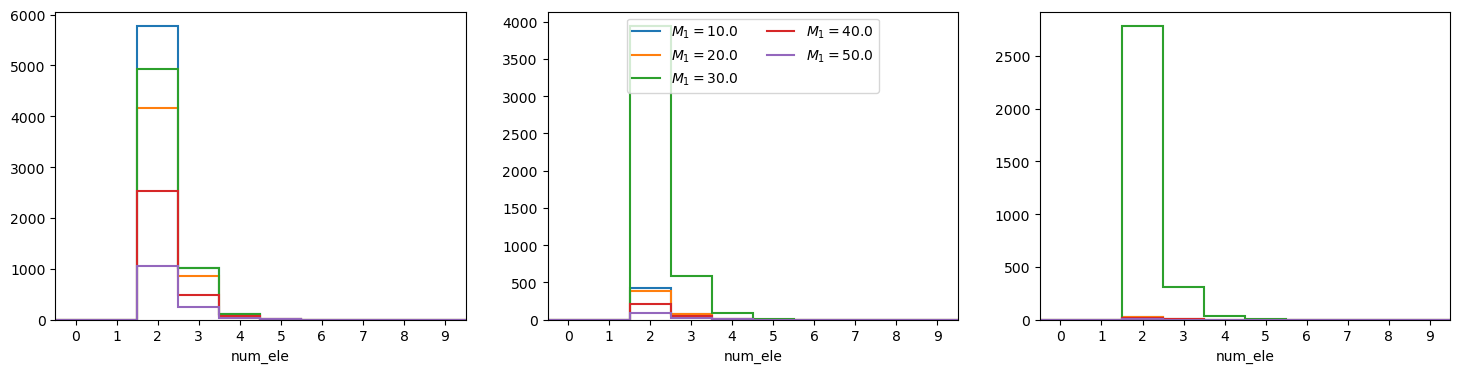

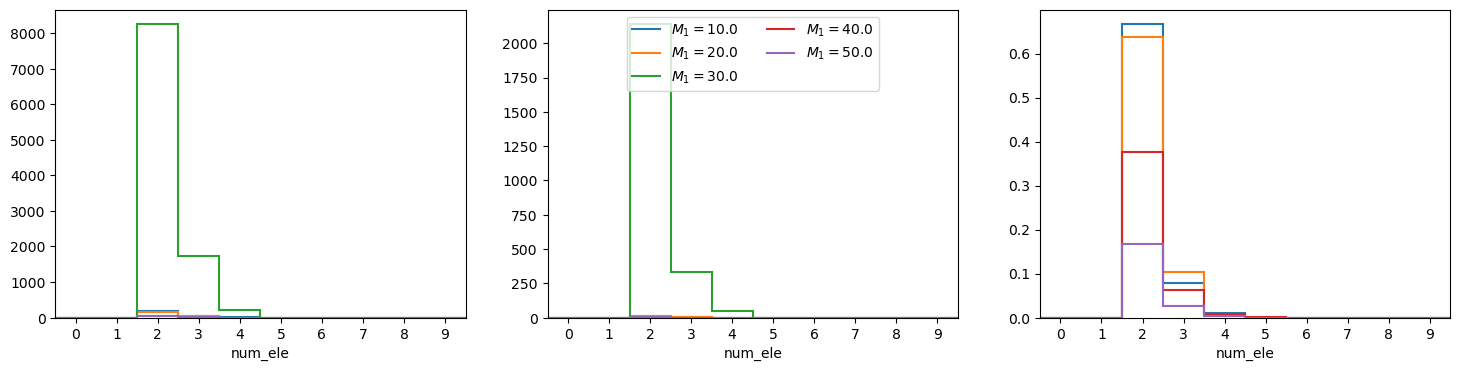

In [8]:
plotSignal("num_electrons",[0,10],rebin=1j,logy=False,scaley=1,xlabel=None,cut="cut7",nameVar="",flow=False)

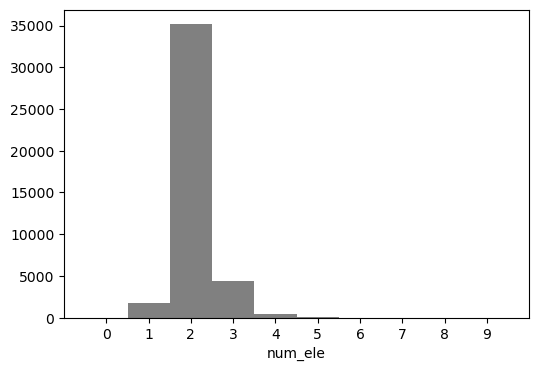

In [11]:
plotBkg("num_electrons",[0,10],rebin=1j,logy=False,scaley=1,xlabel=None,cut="cut7",nameVar="",flow=False)

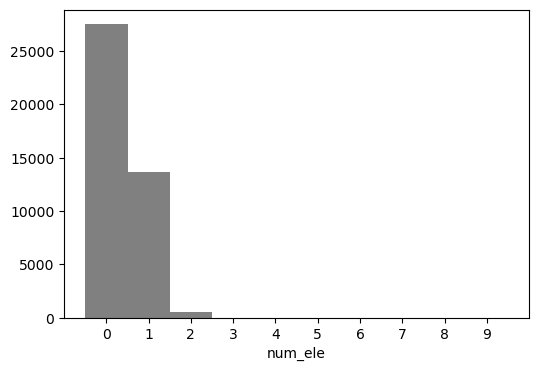

In [17]:
plotBkg("num_reg_electrons",[0,10],rebin=1j,logy=False,scaley=1,xlabel=None,cut="cut7",nameVar="",flow=False)

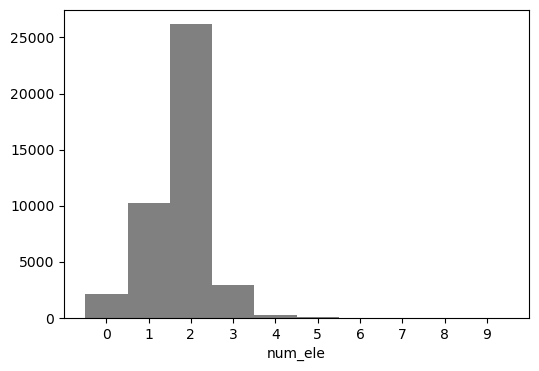

In [18]:
plotBkg("num_lpt_electrons",[0,10],rebin=1j,logy=False,scaley=1,xlabel=None,cut="cut7",nameVar="",flow=False)

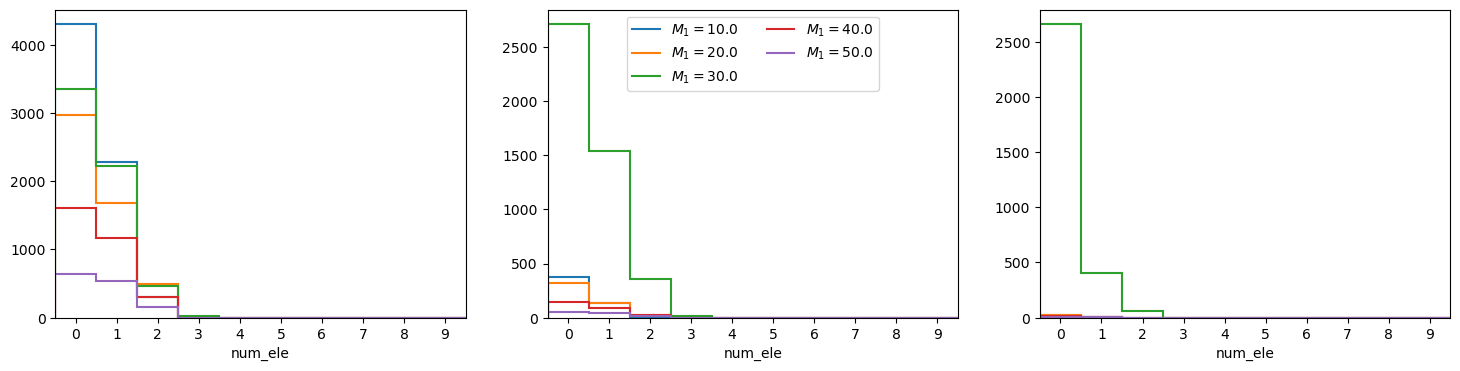

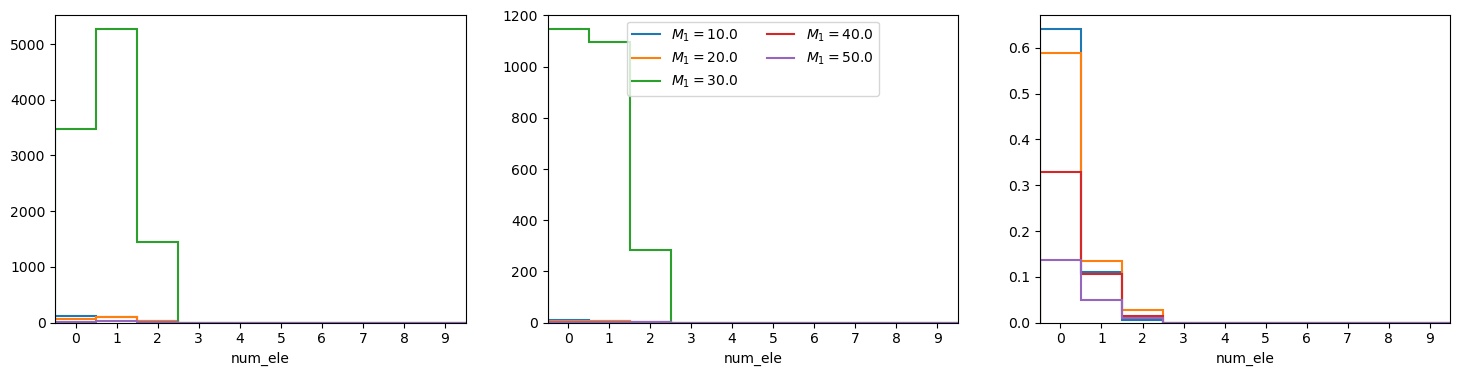

In [19]:
plotSignal("num_reg_electrons",[0,10],rebin=1j,logy=False,scaley=1,xlabel=None,cut="cut7",nameVar="",flow=False)

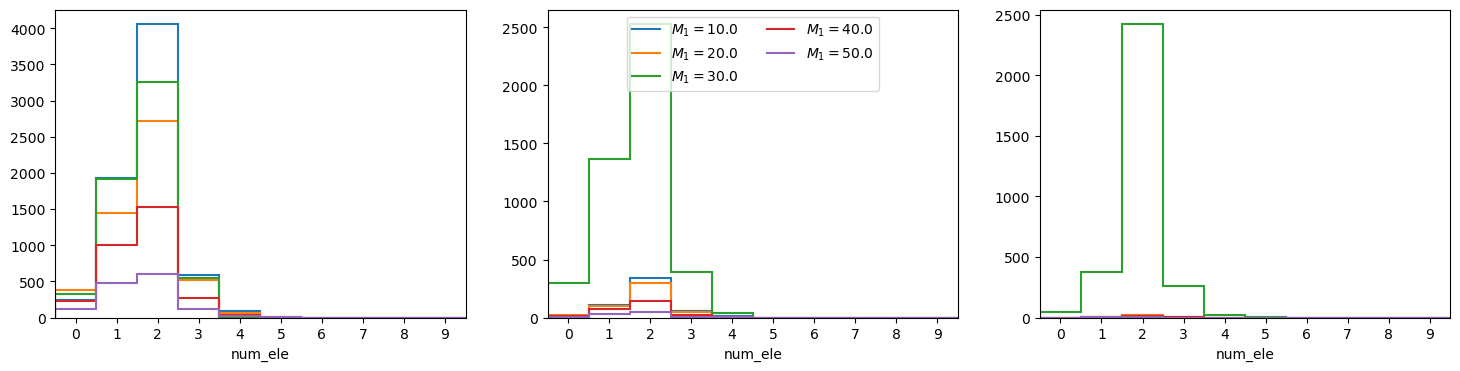

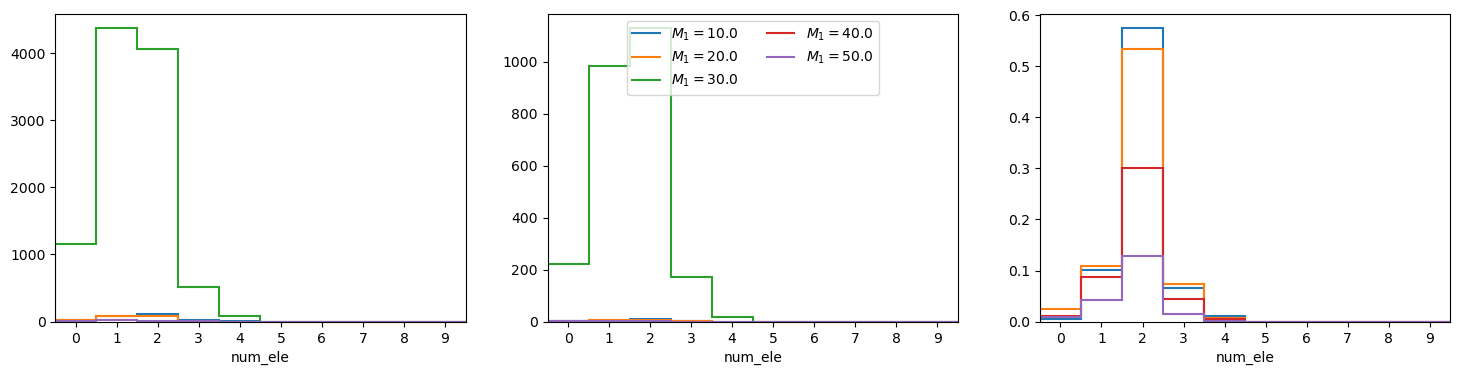

In [20]:
plotSignal("num_lpt_electrons",[0,10],rebin=1j,logy=False,scaley=1,xlabel=None,cut="cut7",nameVar="",flow=False)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fd1905c69d0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fcdb2cda0d0>, text=[])

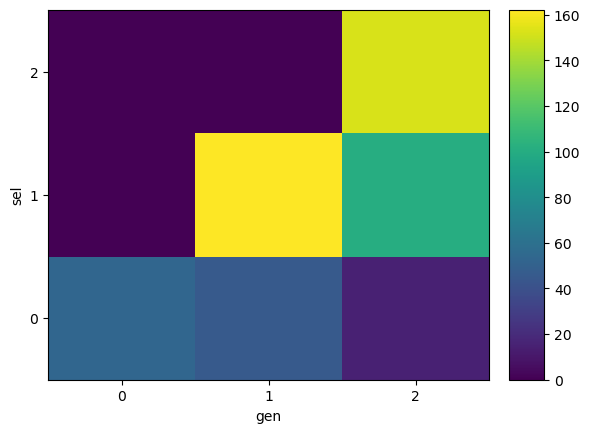

In [23]:
mplhep.hist2dplot(sig['genMatch_vs_vtxMatch'][{"samp":"sig_2018_Mchi-10p5_dMchi-1p0_ctau-1","cut":"cut7"}])